In [165]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
import statsmodels.api as sm

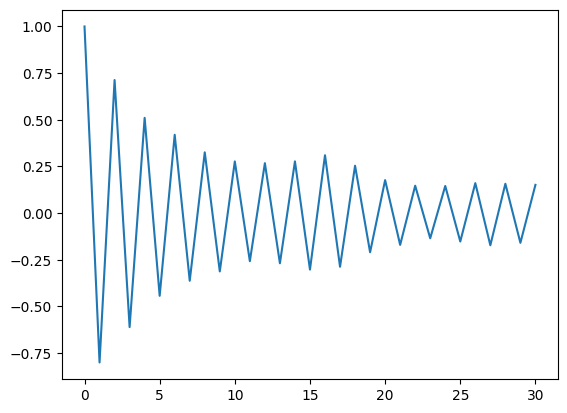

In [166]:
np.random.seed(42)

def AR2(phi_1, phi_2, n=200):
    e = np.random.randn(n)
    X = [e[0], e[1]]

    for t in range(2, n):
        X_t = e[t]-phi_1*X[t-1]-phi_2*X[t-2]
        X.append(X_t)

    return np.array(X)


res = AR2(0.6, -0.3)

emp_acf = acf(res, nlags=30, fft=True)

plt.plot(emp_acf)
plt.show()

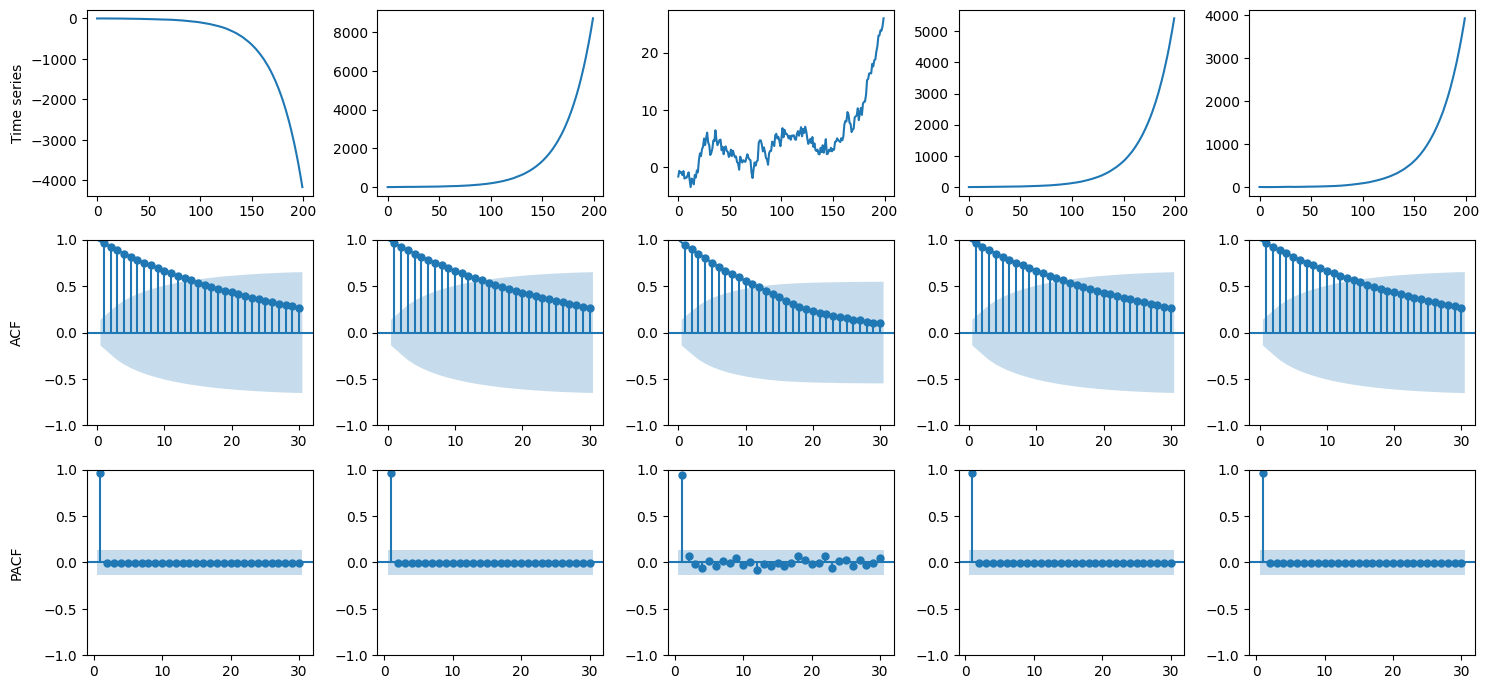

In [167]:
np.random.seed(42)

res = [AR2(-0.75, -0.3) for i in range(5)]

emp_acf = [acf(response, nlags=30, fft=True) for response in res]

fig, ax = plt.subplots(3, 5, figsize=(15, 7))

# Add row titles
# ax[0, 0].set_ylabel("Time series", labelpad=14)
ax[0, 0].set_ylabel("Time series")
ax[1, 0].set_ylabel("ACF", labelpad=14)
ax[2, 0].set_ylabel("PACF", labelpad=14)

for i, value in enumerate(res):
    ax[0, i].plot(value)
    ax[1, i].plot(emp_acf[i])
    # ax[1, i].axhline(0)
    plot_acf(res[i], lags=30, ax=ax[1, i], alpha=0.05, zero=False, color="tab:blue", title="")
    plot_pacf(res[i], lags=30, ax=ax[2, i], alpha=0.05, zero=False, color="tab:blue", title="")

plt.tight_layout()
plt.show()

# Part 2

In [168]:
import pandas as pd

In [169]:
df_solar = pd.read_csv("datasolar.csv")
np.random.seed(42)

In [170]:
Y = df_solar["power"].values

tsf = lambda a : np.log(a) - 5.72
invtsf = lambda a : np.exp(a + 5.72)


In [171]:
np.random.seed(42)
def AR_plant_onestep(Y_t, phi=-0.38, Phi=-0.94, sigma=0.22, n = 36):
    eps = np.random.randn(n) * sigma

    X = list(Y_t)
    pred_onestep= list(Y_t[:13])

    for t in range(13, n):
        X_t = -phi*X[t-1]-Phi*X[t-12]-phi*Phi*X[t-13]
        pred_onestep.append(X_t)
    
    return np.array(pred_onestep)

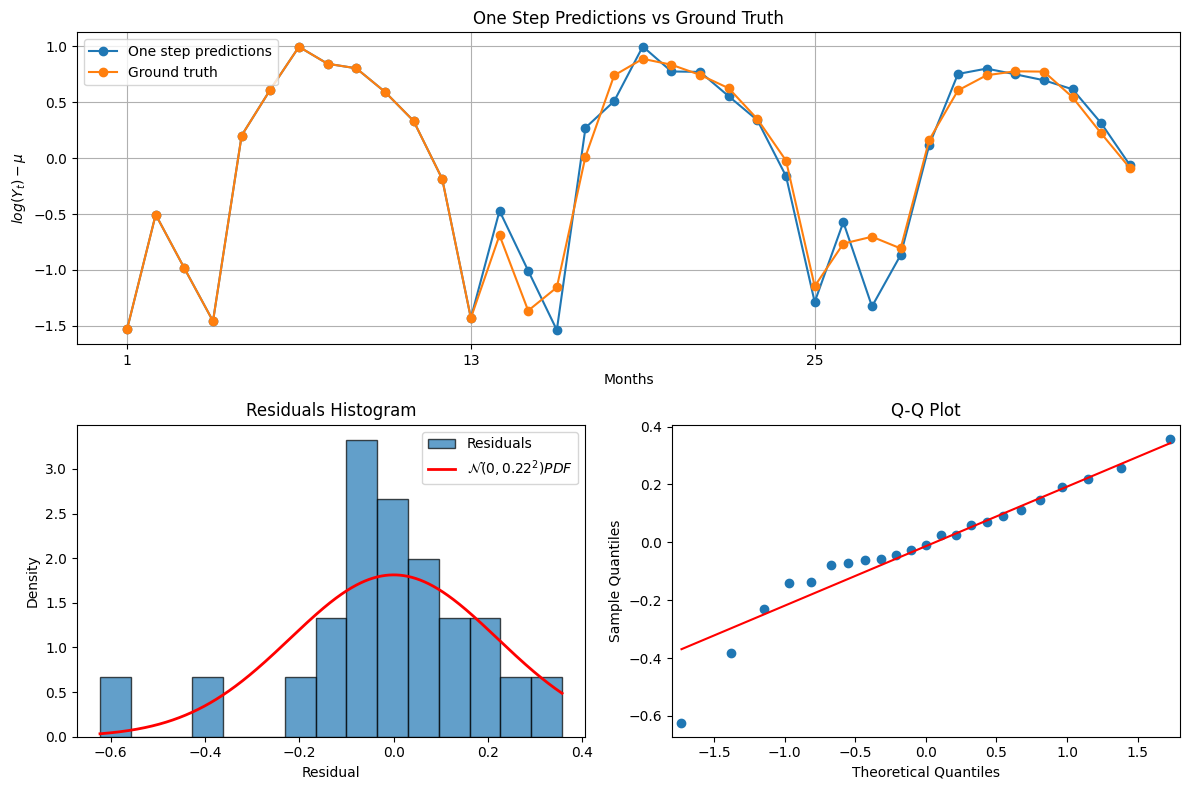

In [172]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import statsmodels.api as sm

# Assume: tsf(Y) is log(Y) - mu
Y_tsf = tsf(Y)
preds = AR_plant_onestep(Y_tsf)
res = preds - Y_tsf
res = res[13:]

fig = plt.figure(figsize=(12, 8))

# Top: Prediction vs Ground Truth (spans two columns)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(np.arange(1, len(Y_tsf)+1), preds, marker='o', label='One step predictions')
ax1.plot(np.arange(1, len(Y_tsf)+1), Y_tsf, marker='o', label='Ground truth')
plt.xticks(np.arange(1, 36, 12))
plt.xlabel("Months")
plt.ylabel("$log(Y_t) - \mu$")
ax1.grid()
ax1.legend(loc='upper left')
ax1.set_title("One Step Predictions vs Ground Truth")

# Bottom left: Histogram with bell curve
ax2 = plt.subplot2grid((2, 2), (1, 0))
count, bins, ignored = ax2.hist(res, density=True, bins=15, alpha=0.7, edgecolor='black', label="Residuals")
x = np.linspace(min(bins), max(bins), 1000)
pdf = norm.pdf(x, 0, 0.22)
ax2.plot(x, pdf, 'r-', lw=2, label='$\mathcal{N}(0, 0.22^2) PDF$')
ax2.legend()
plt.xlabel("Residual")
plt.ylabel("Density")
ax2.set_title("Residuals Histogram")

# Bottom right: Q-Q plot
ax3 = plt.subplot2grid((2, 2), (1, 1))
sm.qqplot(res, line='s', ax=ax3)
ax3.set_title("Q-Q Plot")

plt.tight_layout()
plt.show()


**2.2**

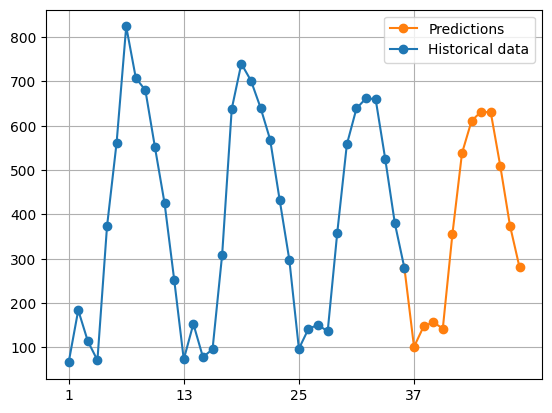

In [173]:
def AR_plant(Y_t, phi=-0.38, Phi=-0.94, sigma=0.22, n=None):

    if n is None:
        n = len(Y_t) + 12  # Forecast 12 months ahead
        
    X = list(Y_t)

    for t in range(len(Y_t), n):
        X_t = -phi*X[t-1]-Phi*X[t-12]-phi*Phi*X[t-13]
        X.append(X_t)
    
    return np.array(X)

plt.plot(np.arange(len(Y), len(Y)+13), invtsf(AR_plant(tsf(Y)))[-13:], marker='o', label="Predictions", color="tab:orange")
plt.plot(np.arange(len(Y))+1, Y, label="Historical data", marker = 'o', color="tab:blue")
plt.xticks(np.arange(1, 48, 12))
plt.grid()
plt.legend()
plt.show()

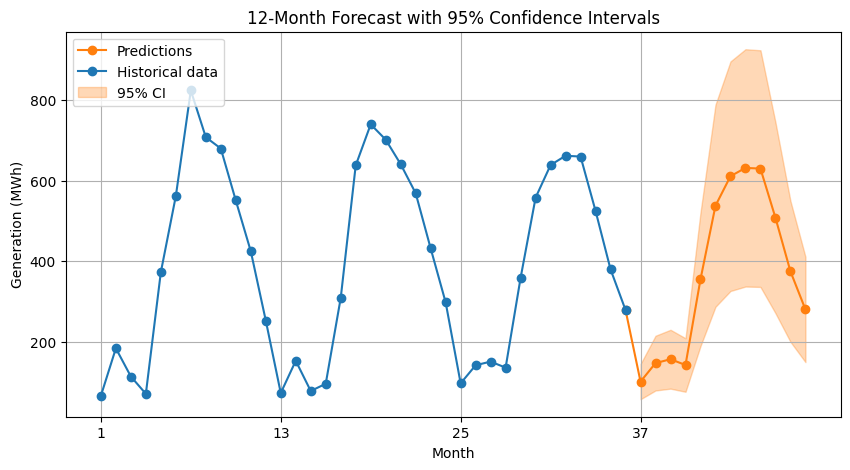

In [174]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

def psi_weights_ar(ar_coeffs, k_max):
    """
    Compute psi-weights for AR model up to k_max steps ahead.
    For ARMA models, use arma2psd or similar tools from statsmodels.
    """
    psi = [1.0]  # ψ₀ = 1
    for k in range(1, k_max):
        next_psi = -sum(ar_coeffs[i] * psi[k - i - 1] for i in range(min(len(ar_coeffs), k)))
        psi.append(next_psi)
    return np.array(psi)

# --- Forecasting ---
phi = -0.38
Phi = -0.94
mu = 5.72
sigma_eps = 0.22

X_full = AR_plant(tsf(Y), phi=phi, Phi=Phi)
X_pred = X_full[-12:]
X_pred_Y = np.exp(X_pred + mu)  # back-transform to original units

# --- Confidence intervals ---
k_steps = 12
ar_coeffs = [phi] + [0]*10 + [Phi] + [phi*Phi]  # include seasonal structure
psi = psi_weights_ar(ar_coeffs, k_steps)

# Prediction error std dev
sigma_k = sigma_eps * np.sqrt(np.cumsum(psi[:k_steps]**2))

# z for 95% CI
z = norm.ppf(0.975)

# Compute CI bounds
lower = X_pred_Y - z * sigma_k * X_pred_Y  # approximate via delta method
upper = X_pred_Y + z * sigma_k * X_pred_Y

# --- Plot ---
months = np.arange(len(Y), len(Y)+12)

plt.figure(figsize=(10, 5))

plt.plot(np.arange(len(Y), len(Y)+13), invtsf(AR_plant(tsf(Y)))[-13:], marker='o', label="Predictions", color="tab:orange")
plt.plot(np.arange(len(Y))+1, Y, label="Historical data", marker = 'o', color="tab:blue")
plt.xticks(np.arange(1, 48, 12))
plt.fill_between(months+1, lower, upper, color='tab:orange', alpha=0.3, label="95% CI")
plt.xlabel("Month")
plt.ylabel("Generation (MWh)")
plt.title("12-Month Forecast with 95% Confidence Intervals")
plt.grid()
plt.legend(loc=2)
plt.show()


# Part 3

In [175]:
df_box = pd.read_csv("box_data_60min.csv")
df_box

,thour,tdate,Ph,Tdelta,Gv,Ph.l0,Ph.l1,Ph.l2,Ph.l3,Ph.l4,...,Gv.l1,Gv.l2,Gv.l3,Gv.l4,Gv.l5,Gv.l6,Gv.l7,Gv.l8,Gv.l9,Gv.l10
0,19,2013-01-30 02:00:00,56,13.253583,-0.498643,56,55,57,57,58,...,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700,8.262339,20.475484
1,20,2013-01-30 03:00:00,54,13.181458,-1.127035,54,56,55,57,57,...,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700,8.262339
2,21,2013-01-30 04:00:00,55,12.968792,-0.643298,55,54,56,55,57,...,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700
3,22,2013-01-30 05:00:00,54,12.667750,-0.456008,54,55,54,56,55,...,-0.643298,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776
4,23,2013-01-30 06:00:00,54,12.605250,-1.534060,54,54,55,54,56,...,-0.456008,-0.643298,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,245,2013-02-08 12:00:00,76,23.684292,264.619541,76,90,94,97,97,...,63.320010,39.317716,10.410304,0.189180,-0.065229,-0.205313,-0.687645,-1.081767,-0.497384,-0.136499
227,246,2013-02-08 13:00:00,58,23.389083,217.417135,58,76,90,94,97,...,264.619541,63.320010,39.317716,10.410304,0.189180,-0.065229,-0.205313,-0.687645,-1.081767,-0.497384
228,247,2013-02-08 14:00:00,63,23.231583,248.983866,63,58,76,90,94,...,217.417135,264.619541,63.320010,39.317716,10.410304,0.189180,-0.065229,-0.205313,-0.687645,-1.081767
229,248,2013-02-08 15:00:00,21,22.566833,638.279086,21,63,58,76,90,...,248.983866,217.417135,264.619541,63.320010,39.317716,10.410304,0.189180,-0.065229,-0.205313,-0.687645


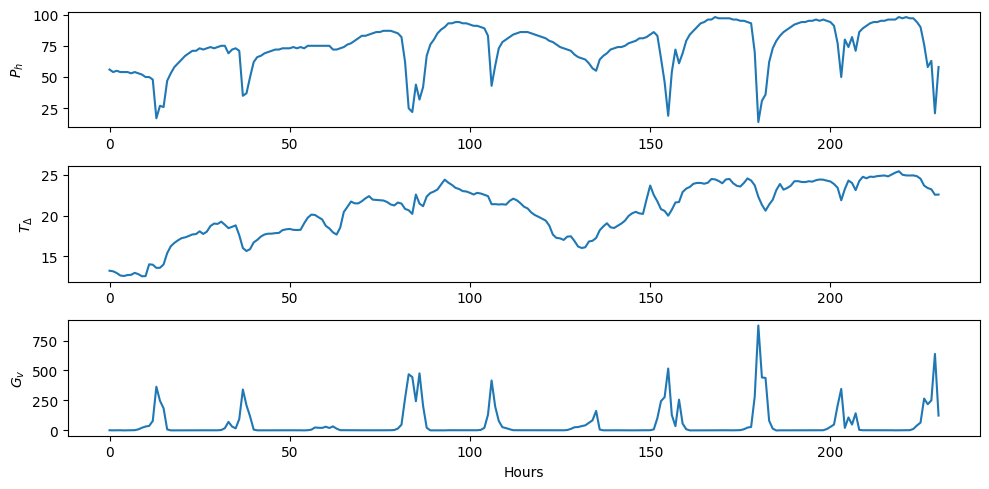

In [176]:
import matplotlib.pyplot as plt

# Line plots
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].plot(df_box['Ph'])
ax[0].set_ylabel('$P_h$')

ax[1].plot(df_box['Tdelta'])
ax[1].set_ylabel('$T_\Delta$')

ax[2].plot(df_box['Gv'])
ax[2].set_ylabel('$G_v$')


plt.xlabel("Hours")
plt.tight_layout()
plt.show()


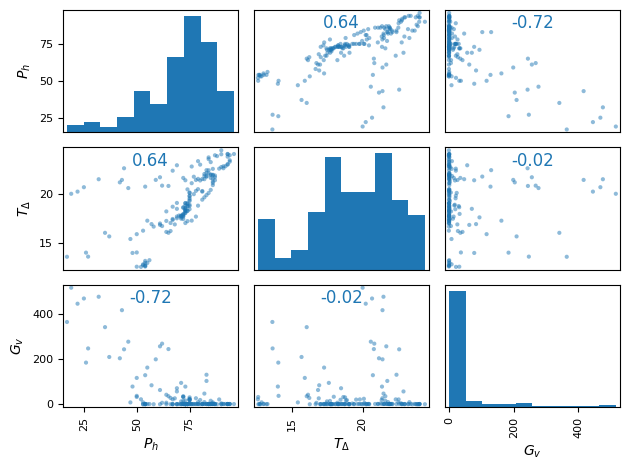

In [177]:
df_train = df_box.iloc[:167] # The dataset doesnt have timestamps for the first 18 hours? lol. This matches with the definition given for the timestamp, but t_hour is 19,...,185, not 1,...,167

df_test = df_box.iloc[167:]

df_train['log ($G_v$)'] = np.log(df_train['Gv'])

df_train['$P_h$'] = df_train['Ph'].values
df_train['$T_\Delta$'] = df_train['Tdelta'].values
df_train['$G_v$'] = df_train['Gv'].values

df_selected = df_train[['$P_h$',
                        '$T_\Delta$',
                        '$G_v$']]

axes = pd.plotting.scatter_matrix(df_selected)

cols = df_selected.columns
n = len(cols)

# Loop through upper triangle to add correlation coefficients
for i in range(n):
    for j in range(n):
        # if i < j:
        if i is not j:
            corr = np.corrcoef(df_selected[cols[j]], df_selected[cols[i]])[0, 1]
            ax = axes[i, j]
            ax.annotate(f"{corr:.2f}", xy=(0.5, 0.85), xycoords='axes fraction',
                        ha='center', fontsize=12, color='tab:blue')


plt.tight_layout()
plt.show()

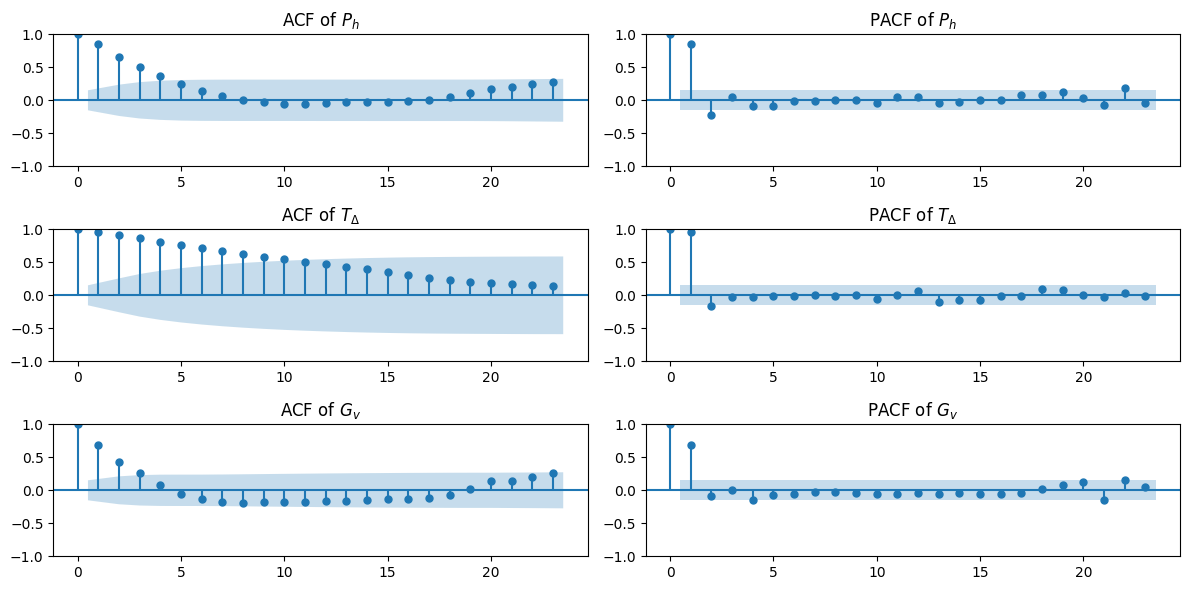

In [178]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

variables = ['$P_h$', '$T_\Delta$', '$G_v$']

fig, axes = plt.subplots(len(variables), 2, figsize=(12, 6))

for i, var in enumerate(variables):
    plot_acf(df_train[var], ax=axes[i, 0], title=f"ACF of {var}")
    plot_pacf(df_train[var], ax=axes[i,1], title=f"PACF of {var}")
    # plt.ylabel("autocorrelation")

plt.tight_layout()
plt.show()


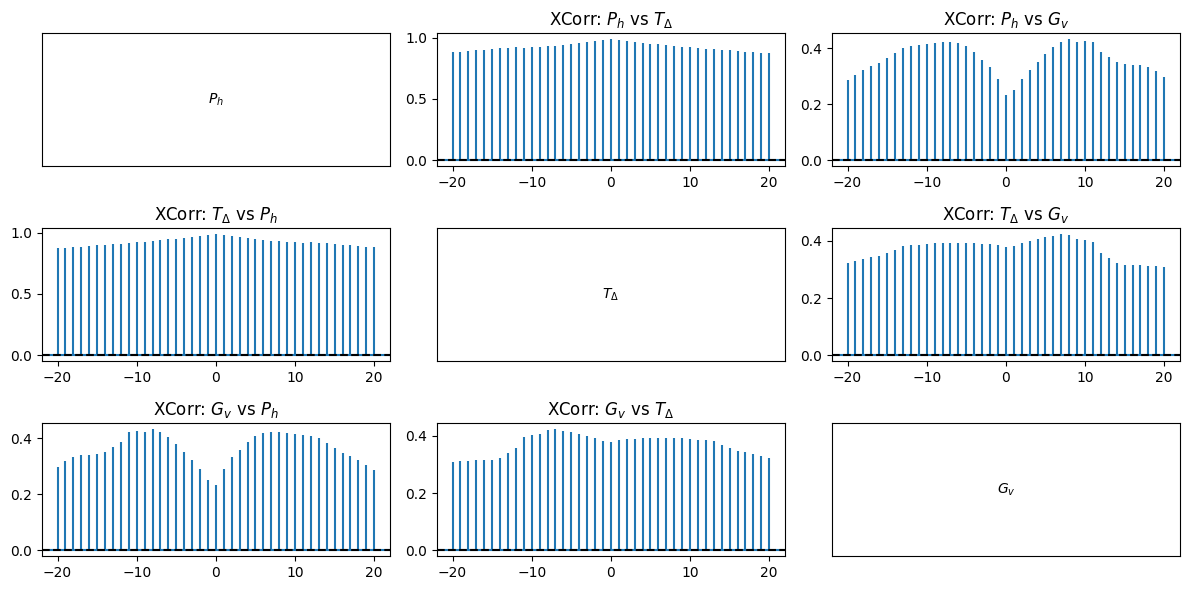

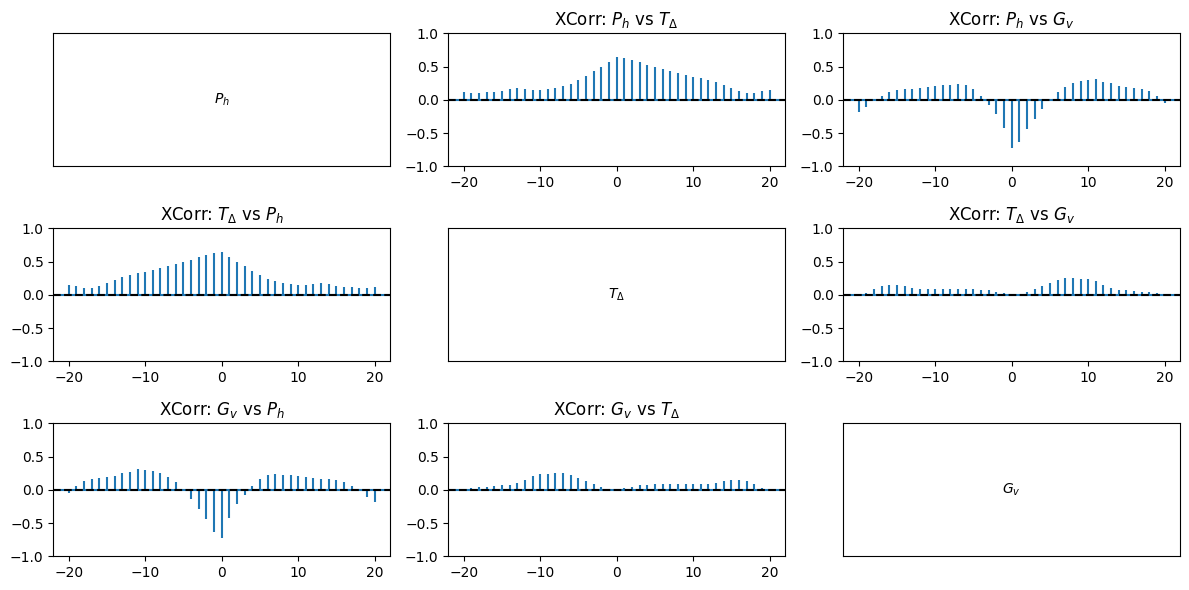

In [179]:
# Alternative cross-correlation using plt.xcorr
fig, axes = plt.subplots(len(variables), len(variables), figsize=(12, 6))

for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i == j:
            axes[i, j].text(0.5, 0.5, var1, ha='center', va='center')
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
        else:
            axes[i, j].xcorr(df_train[var1], df_train[var2], maxlags=20)
            axes[i, j].set_title(f"XCorr: {var1} vs {var2}")
            axes[i, j].axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

import numpy as np

fig, axes = plt.subplots(len(variables), len(variables), figsize=(12, 6))

# Set y-limits for cross-correlation
xcorr_ylim = (-1, 1)

for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i == j:
            # Diagonal: variable name
            axes[i, j].text(0.5, 0.5, var1, ha='center', va='center')
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
        else:
            # Cross-correlation with fixed ylim
            axes[i, j].xcorr(
                df_train[var1] - df_train[var1].mean(),
                df_train[var2] - df_train[var2].mean(),
                maxlags=20,
                normed=True,
            )
            axes[i, j].set_ylim(xcorr_ylim)
            axes[i, j].axhline(0, color='black', linestyle='--')
            axes[i, j].set_title(f"XCorr: {var1} vs {var2}")

plt.tight_layout()
plt.show()

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.54       14.60   2.062e+06       14.56
1        8.873      9.106*       7135.       8.968
2        8.736       9.144       6222.      8.902*
3        8.713       9.297       6087.       8.951
4        8.636       9.395       5635.       8.944
5       8.608*       9.542      5486.*       8.987
6        8.643       9.752       5690.       9.094
7        8.697       9.982       6020.       9.219
8        8.778       10.24       6544.       9.371
9        8.819       10.45       6842.       9.483
10       8.908       10.72       7506.       9.643
--------------------------------------------------


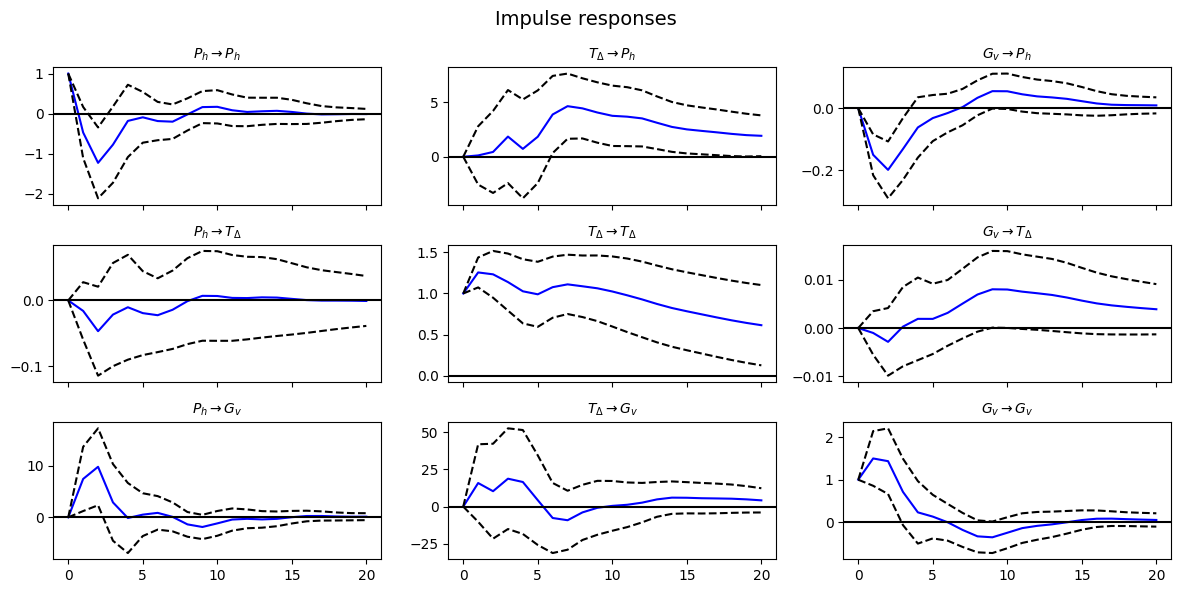

In [180]:
from statsmodels.tsa.api import VAR

# Ensure data is stationary (difference if needed)
df_stationary = df_train[df_train.columns[-3:]]
# Fit VAR model (choose optimal lag order)
model = VAR(df_stationary)
lag_order = model.select_order(maxlags=10)  # Choose based on AIC/BIC
print(lag_order.summary())

# Fit model with selected lags
results = model.fit(maxlags=lag_order.aic, ic='aic')

# Compute IRF
irf = results.irf(periods=20)  # Adjust periods as needed

# Plot IRF
irf.plot(figsize=(12, 6), 
         subplot_params={'fontsize': 10})
plt.tight_layout()
plt.show()

In [181]:
def calculate_aic_bic(y_true, y_pred, k):
    n = len(y_true)
    rss = np.sum((y_true - y_pred) ** 2)
    aic = n * np.log(rss / n) + 2 * k
    bic = n * np.log(rss / n) + k * np.log(n)
    return aic, bic

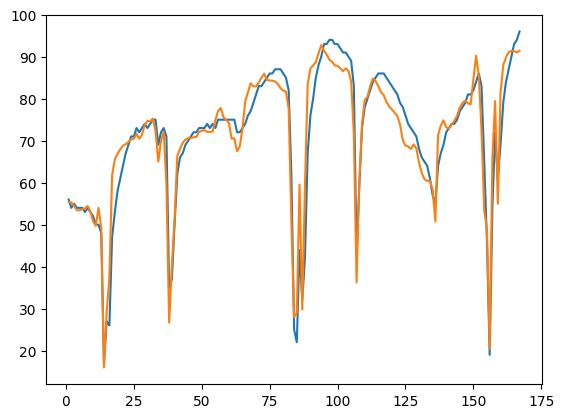

In [182]:
from sklearn import linear_model as lm
# P_h, t = omega_1*T_delta, t + omega_2*G_v,t + eps_t
y = df_train['$P_h$']
X = df_train[['$T_\Delta$', '$G_v$']]
reg = lm.LinearRegression().fit(X,y)


y_pred = reg.predict(X)
x_ticks = np.linspace(1, len(y.values), num = len(y.values))
plt.plot(x_ticks, df_train['$P_h$'])
plt.plot(x_ticks, y_pred)

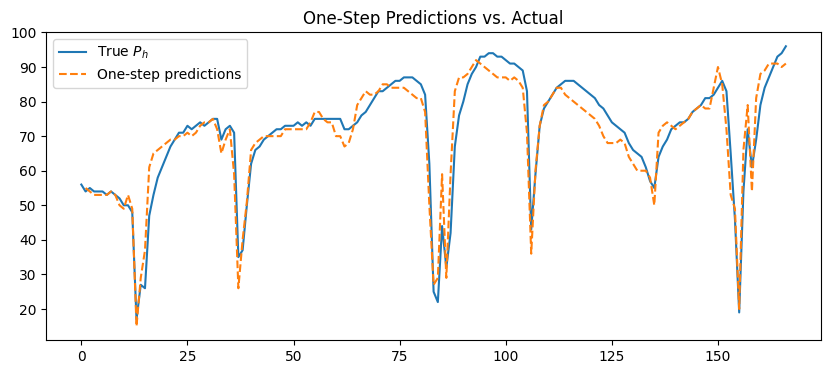

553.1459526626168 562.4819160276863


167

In [183]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
# Extract data
y = df_train['$P_h$'].values
X = df_train[['$T_\Delta$', '$G_v$']].values

# Initialize arrays to store one-step predictions
y_pred_one_step = np.zeros_like(y)
y_pred_one_step[:] = 60  # Leave first value as NaN (no prior data)

# Iterate to create one-step forecasts
reg_lr = LinearRegression().fit(X, y)
for t in range(1, len(y)):
    # reg = LinearRegression().fit(X[:t], y[:t])  # Fit on data up to t-1
    y_pred_one_step[t] = reg_lr.predict(X[t].reshape(1, -1))  # Predict t

plt.figure(figsize=(10, 4))
plt.plot(y, label='True $P_h$')
plt.plot(x_ticks[1:]-1, y_pred_one_step[1:], label='One-step predictions', linestyle='--')
plt.legend()
plt.title("One-Step Predictions vs. Actual")
plt.show()


aic_1, bic_1 = calculate_aic_bic(y[1:], y_pred_one_step[1:], k=3)
print(aic_1, bic_1)
len(y_pred_one_step)

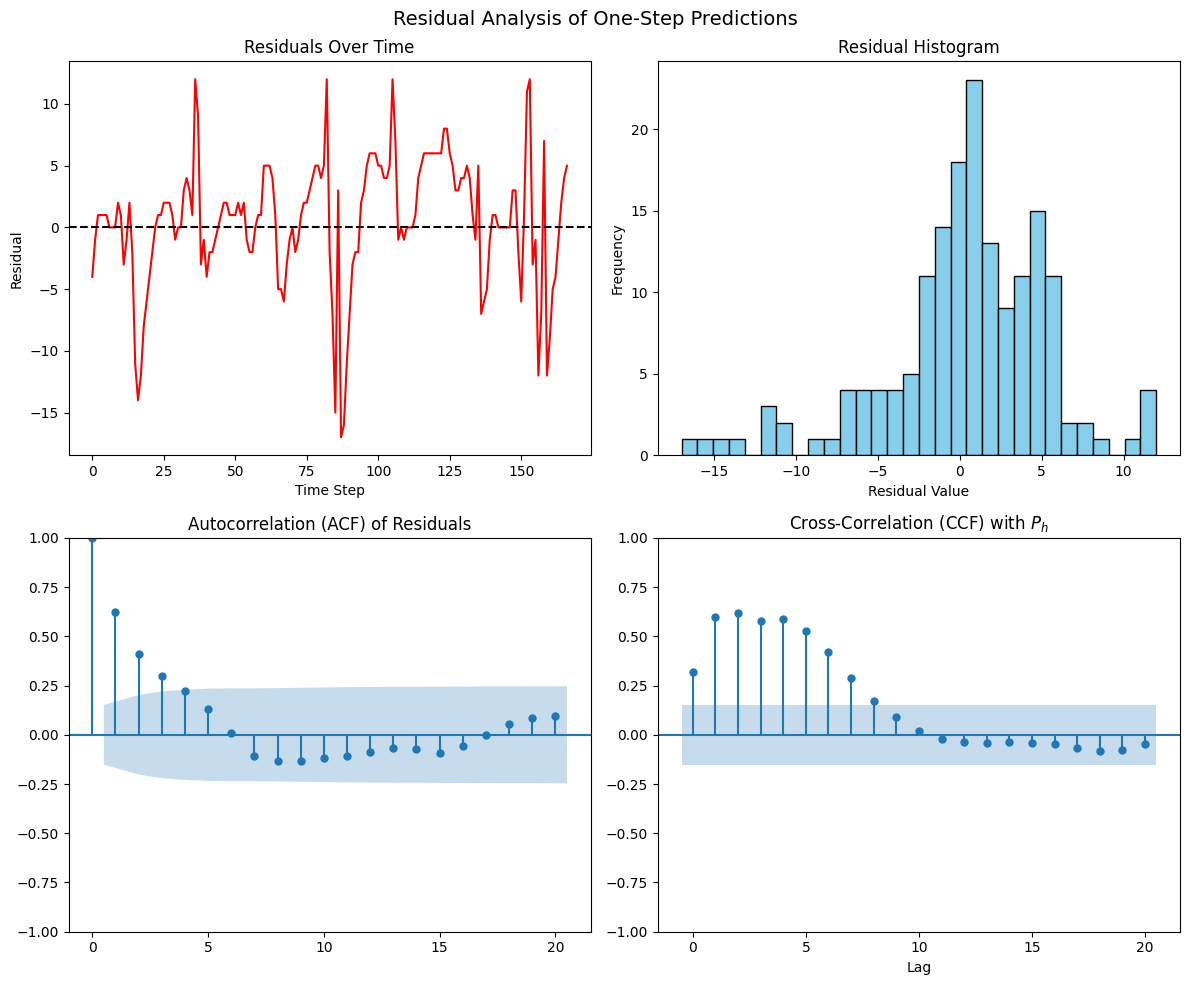

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf
from sklearn.linear_model import LinearRegression

# Assuming y, X, and y_pred_one_step are already defined as in your code

# Calculate residuals
residuals = y - y_pred_one_step  # Skip the first NaN value
# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Residual Analysis of One-Step Predictions", fontsize=14)

# Plot 1: Residuals over time
axes[0, 0].plot(residuals, color='red')
axes[0, 0].axhline(y=0, color='black', linestyle='--')
axes[0, 0].set_title("Residuals Over Time")
axes[0, 0].set_xlabel("Time Step")
axes[0, 0].set_ylabel("Residual")

# Plot 2: Residual histogram
axes[0, 1].hist(residuals, bins=30, edgecolor='black', color='skyblue')
axes[0, 1].set_title("Residual Histogram")
axes[0, 1].set_xlabel("Residual Value")
axes[0, 1].set_ylabel("Frequency")

# Plot 3: ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title("Autocorrelation (ACF) of Residuals")

# Plot 4: CCF between residuals and input features (example: TΔ)
plot_ccf(residuals, y[1:], lags=20, ax=axes[1, 1], alpha=0.05)  # X[1:,0] is TΔ
axes[1, 1].set_title("Cross-Correlation (CCF) with $P_h$")
axes[1, 1].set_xlabel("Lag")

plt.tight_layout()
plt.show()

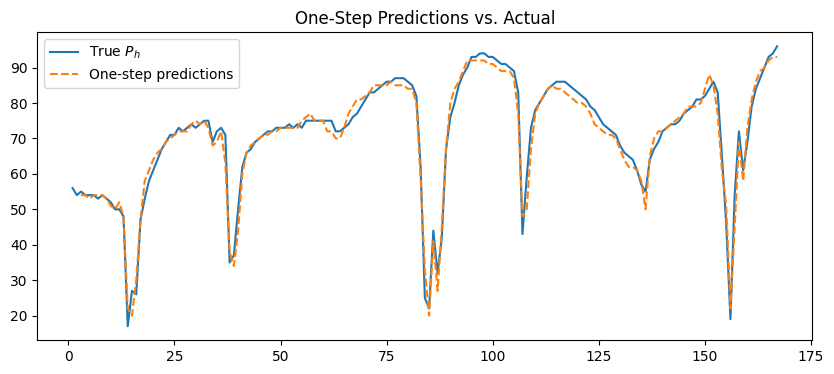

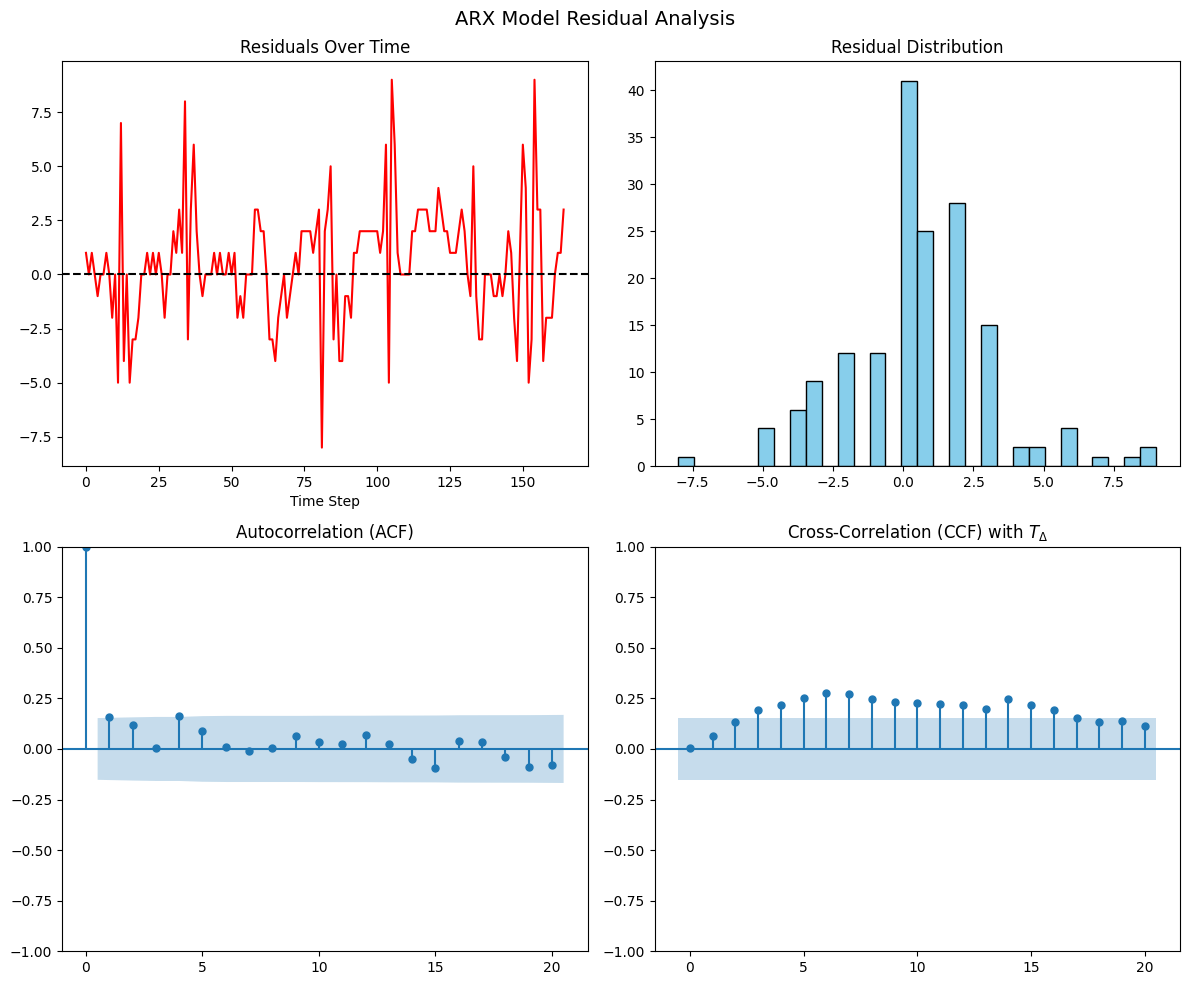

ARX Model Residual Variance: 5.093862547354013e+35
Previous Model Residual Variance: 26.731347075047182
329.7673768704311 339.08521329213283


In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf
from sklearn.linear_model import LinearRegression

# Extract data
y = df_train['$P_h$'].values
X = df_train[['$T_\Delta$', '$G_v$']].values

# Create lagged Ph,t-1 feature
y_lagged = np.roll(y, 1)  # Shift y by 1 step
y_lagged[0] = 56      # First value is NaN (no prior data)

X_arx = np.column_stack([y_lagged, X])

y_pred_arx = np.full_like(y, np.nan)
y_pred_arx[0] = y[0]  # Initialize first step (optional)


reg_arx1 = LinearRegression().fit(X_arx, y)
for t in range(2, len(y)):
    # reg = LinearRegression().fit(X_arx[1:t], y[1:t])  # Fit up to t-1
    y_pred_arx[t] = reg_arx1.predict(X_arx[t].reshape(1, -1))  # Predict t

# Calculate residuals
residuals_arx = y[1:] - y_pred_arx[1:]

plt.figure(figsize=(10, 4))
plt.title("One-Step Predictions vs. Actual")
plt.plot(x_ticks, y, label='True $P_h$')
plt.plot(x_ticks[2:], y_pred_arx[2:], label='One-step predictions', linestyle='--')
plt.legend()
plt.show()

# --- Residual Analysis (2x2 Plot) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("ARX Model Residual Analysis", fontsize=14)

# 1. Residuals over time
axes[0, 0].plot(residuals_arx[1:], color='red') 
axes[0, 0].axhline(0, linestyle='--', color='black')
axes[0, 0].set_title("Residuals Over Time")
axes[0, 0].set_xlabel("Time Step")

# 2. Residual histogram
axes[0, 1].hist(residuals_arx[1:], bins=30, color='skyblue', edgecolor='black')
axes[0, 1].set_title("Residual Distribution")

# 3. ACF of residuals
plot_acf(residuals_arx[1:], lags=20, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title("Autocorrelation (ACF)")

# 4. CCF with TΔ
plot_ccf(residuals_arx[1:], X[1:, 0], lags=20, ax=axes[1, 1], alpha=0.05)  # TΔ
axes[1, 1].set_title("Cross-Correlation (CCF) with $T_\Delta$")

plt.tight_layout()
plt.show()

# --- Compare with Previous Model ---
residuals_prev = y[1:] - y_pred_one_step[1:]  # From your earlier code
print("ARX Model Residual Variance:", np.var(residuals_arx))
print("Previous Model Residual Variance:", np.var(residuals_prev))

aic_2, bic_2 = calculate_aic_bic(y[2:], y_pred_arx[2:], k=3)
print(aic_2, bic_2)


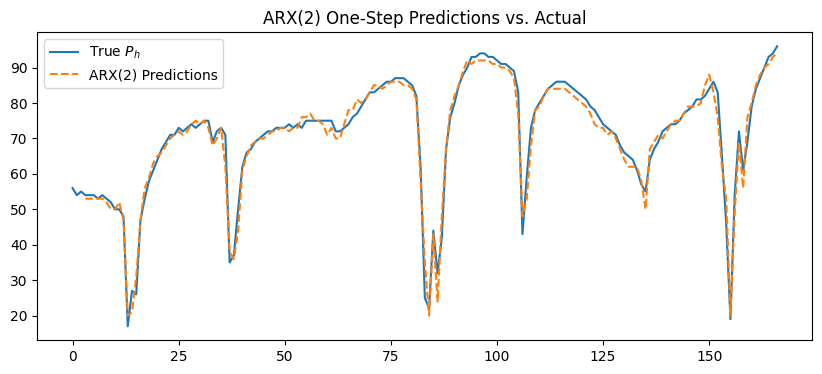

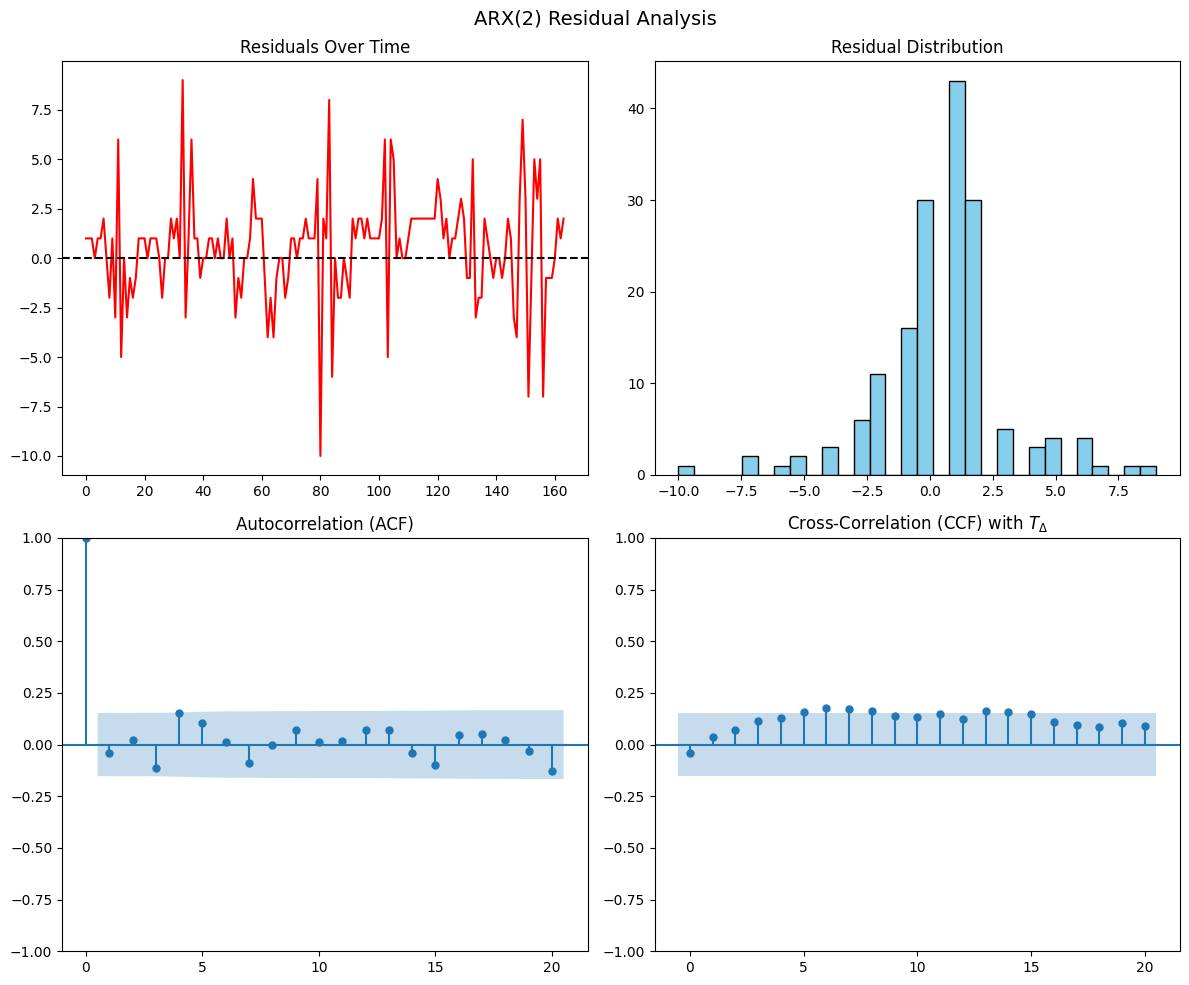

ARX(1) Residual Variance: 5.093862547354013e+35
ARX(2) Residual Variance: 6.650059488399761
329.9824066245522 348.5816051914974


In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_ccf
from sklearn.linear_model import LinearRegression

# Extract data
y = df_train['$P_h$'].values
X = df_train[['$T_\Delta$', '$G_v$']].values

# Create lagged features for ARX(2)
y_lagged_1 = np.roll(y, 1)  # P_{h,t-1}
y_lagged_2 = np.roll(y, 2)  # P_{h,t-2}

# Lagged input features (TΔ and Gv at t and t-1)
T_lagged = np.roll(X[:, 0], 1)  # TΔ_{t-1}
G_lagged = np.roll(X[:, 1], 1)  # Gv_{t-1}

# Combine all features: [P_{h,t-1}, P_{h,t-2}, TΔ_t, TΔ_{t-1}, Gv_t, Gv_{t-1}]
X_arx2 = np.column_stack([
    y_lagged_1, y_lagged_2, 
    X[:, 0], T_lagged,        # TΔ terms
    X[:, 1], G_lagged         # Gv terms
])

# Initialize one-step predictions
y_pred_arx2 = np.full_like(y, np.nan)
y_pred_arx2[:2] = y[:2]  # First two steps initialized (no enough lags)

# Iterate to fit ARX(2) model (one-step ahead)
reg_arx2 = LinearRegression().fit(X_arx2, y)  # Fit up to t-1
for t in range(3, len(y)):
    y_pred_arx2[t] = reg_arx2.predict(X_arx2[t].reshape(1, -1))  # Predict t

# Calculate residuals
residuals_arx2 = y[3:] - y_pred_arx2[3:]

# --- Plot Predictions ---
plt.figure(figsize=(10, 4))
plt.title("ARX(2) One-Step Predictions vs. Actual")
plt.plot(y, label='True $P_h$')
plt.plot(x_ticks[3:]-1, y_pred_arx2[3:], label='ARX(2) Predictions', linestyle='--')
plt.legend()
plt.show()

# --- Residual Analysis (2x2 Plot) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("ARX(2) Residual Analysis", fontsize=14)

# 1. Residuals over time
axes[0, 0].plot(residuals_arx2, color='red')
axes[0, 0].axhline(0, linestyle='--', color='black')
axes[0, 0].set_title("Residuals Over Time")

# 2. Residual histogram
axes[0, 1].hist(residuals_arx2, bins=30, color='skyblue', edgecolor='black')
axes[0, 1].set_title("Residual Distribution")

# 3. ACF of residuals
plot_acf(residuals_arx2, lags=20, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title("Autocorrelation (ACF)")

# 4. CCF with TΔ
plot_ccf(residuals_arx2, X[2:, 0], lags=20, ax=axes[1, 1], alpha=0.05)  # TΔ
axes[1, 1].set_title("Cross-Correlation (CCF) with $T_\Delta$")

plt.tight_layout()
plt.show()

# --- Compare Models ---
print("ARX(1) Residual Variance:", np.var(residuals_arx))
print("ARX(2) Residual Variance:", np.var(residuals_arx2))

aic_3, bic_3 = calculate_aic_bic(y[3:], y_pred_arx2[3:], k=6)
print(aic_3, bic_3)

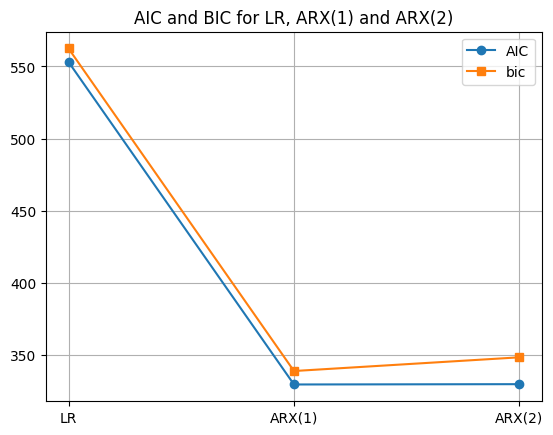

In [187]:
plt.plot([1, 2, 3],[aic_1, aic_2, aic_3], label='AIC', marker='o')
plt.plot([1, 2, 3],[bic_1, bic_2, bic_3], label='bic', marker='s')


plt.xticks([1, 2, 3], ['LR', 'ARX(1)', 'ARX(2)'])
plt.legend()
plt.grid()
plt.title("AIC and BIC for LR, ARX(1) and ARX(2)")
plt.show()

In [188]:
# def rmse(y_true, y_pred):
#     return (np.sqrt(np.mean((y_true-y_pred)**2)))


# df_test
# test_set = df_test[['Ph', 'Tdelta', "Gv"]]
# y_test = test_set['Ph']

# y_test_l_1 = np.roll(y_test, 1)  # P_{h,t-1}
# y_test_l_2 = np.roll(y_test, 2)  # P_{h,t-2}

# y_test_l_1[0] = y[-1]

# y_test_l_2[0] = y[-2]
# y_test_l_2[1] = y[-1]

# test_set['l1'] = y_test_l_1
# test_set['l2'] = y_test_l_2

# # g_test_l1 = np.roll()


# # Linear reg
# X_lr = test_set[['Tdelta', 'Gv']]

# lr_pred = reg_lr.predict(X_lr)
# lr_rmse = rmse(y_test, lr_pred)


# #ARX(1)

# X_arx1 = test_set[['l1','Tdelta', 'Gv']]
# arx1_pred = reg_arx1.predict(X_arx1)
# arx1_rmse = rmse(y_test, arx1_pred)


# #ARX(2)


# X_arx2 = test_set[['l1', 'l2','Tdelta', 'Gv']]
# arx2_pred = reg_arx2.predict(X_arx2)
# arx2_rmse = rmse(y_test, arx2_pred)


# #Plotting

# fig, ax = plt.subplots(3, 1, figsize=(10,6))

# ax[0].plot(y_test.values, label = "ground truth")
# ax[0].plot(lr_pred)
# ax[0].set_xlabel(f"ARX(2), RMSE = {lr_rmse:.2f}")

# ax[1].plot(y_test.values, label = "ground truth")
# ax[1].plot(arx1_pred)
# ax[1].set_xlabel(f"ARX(2), RMSE = {arx1_rmse:.2f}")

# ax[2].plot(y_test.values)
# ax[2].plot(lr_pred)
# ax[2].set_xlabel("ARX(2), RMSE = 0")
# plt.tight_layout()
# plt.show()

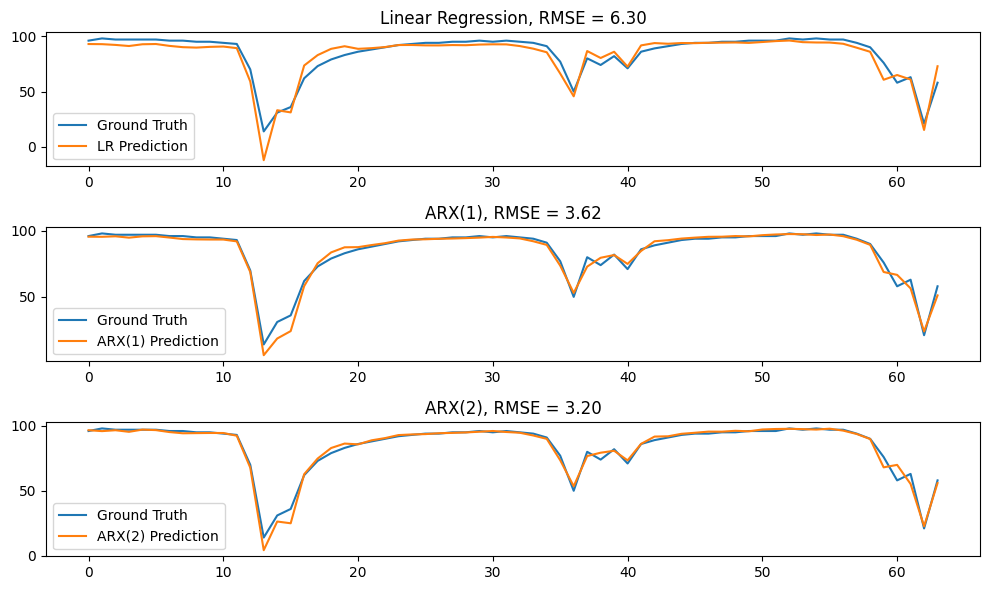

In [189]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Prepare test set
test_set = df_test[['Ph', 'Tdelta', 'Gv']].copy()
y_test = test_set['Ph']

# Lag Ph
y_test_l1 = np.roll(y_test, 1)
y_test_l2 = np.roll(y_test, 2)
y_test_l1[0] = y[-1]
y_test_l2[0] = y[-2]
y_test_l2[1] = y[-1]

# Lag Tdelta
tdelta_test = test_set['Tdelta']
tdelta_l1 = np.roll(tdelta_test, 1)
tdelta_l2 = np.roll(tdelta_test, 2)
tdelta_l1[0] = df_train['$T_\Delta$'].iloc[-1]
tdelta_l2[0] = df_train['$T_\Delta$'].iloc[-2]
tdelta_l2[1] = df_train['$T_\Delta$'].iloc[-1]

# Lag Gv
gv_test = test_set['Gv']
gv_l1 = np.roll(gv_test, 1)
gv_l2 = np.roll(gv_test, 2)
gv_l1[0] = df_train['$G_v$'].iloc[-1]
gv_l2[0] = df_train['$G_v$'].iloc[-2]
gv_l2[1] = df_train['$G_v$'].iloc[-1]

# Add features to test_set
test_set['l1'] = y_test_l1
test_set['l2'] = y_test_l2
test_set['Tdelta_l1'] = tdelta_l1
test_set['Tdelta_l2'] = tdelta_l2
test_set['Gv_l1'] = gv_l1
test_set['Gv_l2'] = gv_l2

# Feature sets
X_lr = test_set[['Tdelta', 'Gv']]
X_arx1 = test_set[['l1', 'Tdelta', 'Gv']]
X_arx2 = test_set[['l1', 'l2', 'Tdelta', 'Tdelta_l1', 'Gv', 'Gv_l1']]

# Predictions
lr_pred = reg_lr.predict(X_lr)
arx1_pred = reg_arx1.predict(X_arx1)
arx2_pred = reg_arx2.predict(X_arx2)

# RMSE
lr_rmse = rmse(y_test, lr_pred)
arx1_rmse = rmse(y_test, arx1_pred)
arx2_rmse = rmse(y_test, arx2_pred)

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 6))

ax[0].plot(y_test.values, label="Ground Truth")
ax[0].plot(lr_pred, label="LR Prediction")
ax[0].set_title(f"Linear Regression, RMSE = {lr_rmse:.2f}")
ax[0].legend()

ax[1].plot(y_test.values, label="Ground Truth")
ax[1].plot(arx1_pred, label="ARX(1) Prediction")
ax[1].set_title(f"ARX(1), RMSE = {arx1_rmse:.2f}")
ax[1].legend()

ax[2].plot(y_test.values, label="Ground Truth")
ax[2].plot(arx2_pred, label="ARX(2) Prediction")
ax[2].set_title(f"ARX(2), RMSE = {arx2_rmse:.2f}")
ax[2].legend()

plt.tight_layout()
plt.show()

In [190]:
df_box.columns

Index(['thour', 'tdate', 'Ph', 'Tdelta', 'Gv', 'Ph.l0', 'Ph.l1', 'Ph.l2',
       'Ph.l3', 'Ph.l4', 'Ph.l5', 'Ph.l6', 'Ph.l7', 'Ph.l8', 'Ph.l9', 'Ph.l10',
       'Tdelta.l0', 'Tdelta.l1', 'Tdelta.l2', 'Tdelta.l3', 'Tdelta.l4',
       'Tdelta.l5', 'Tdelta.l6', 'Tdelta.l7', 'Tdelta.l8', 'Tdelta.l9',
       'Tdelta.l10', 'Gv.l0', 'Gv.l1', 'Gv.l2', 'Gv.l3', 'Gv.l4', 'Gv.l5',
       'Gv.l6', 'Gv.l7', 'Gv.l8', 'Gv.l9', 'Gv.l10'],
      dtype='object')

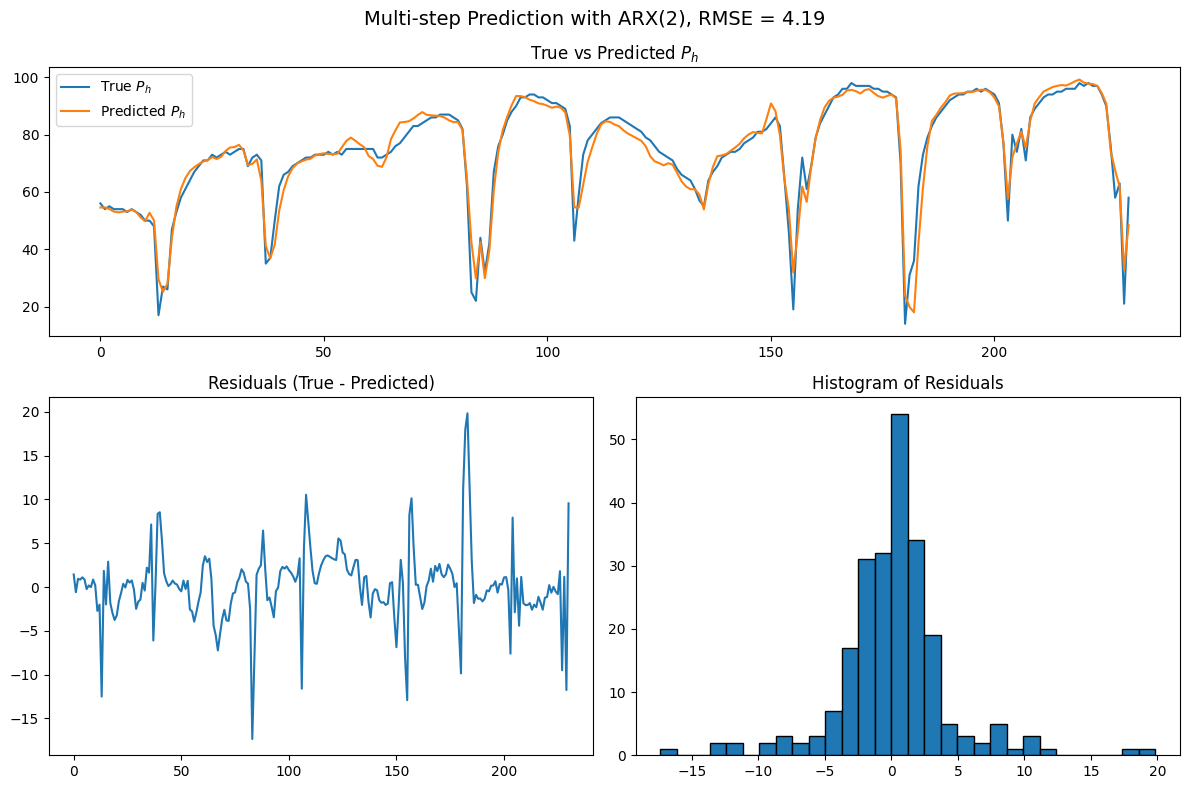

In [198]:
df_full_x = df_box[['Tdelta', 'Tdelta.l1', 'Gv', 'Gv.l0']]

Ph_val = df_box['Ph'].values
Ph = [Ph_val[0], Ph_val[1]]  # seed with first two true values

for _, row in df_full_x.iterrows():
    X = row.values
    X = np.insert(X, 0, [Ph[-1], Ph[-2]])  # Insert lagged Ph values
    X = np.array(X).reshape(1, -1)  # Reshape to (1, n_features)
    Ph.append(reg_arx2.predict(X)[0])  # Predict and append scalar

rmse_full = rmse(Ph_val, Ph[2:])

# Calculate residualsimport matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Calculate residuals
predicted = np.array(Ph[2:])
residuals = Ph_val - predicted
rmse_full = rmse(Ph_val, predicted)

# Set up the grid layout
fig = plt.figure(figsize=(12, 8))
fig.suptitle(f"Multi-step Prediction with ARX(2), RMSE = {rmse_full:.2f}", fontsize=14)
gs = gridspec.GridSpec(2, 2, height_ratios=[0.75, 1])  # 2 rows, 2 columns

# First row: full prediction vs ground truth (span both columns)
ax0 = fig.add_subplot(gs[0, :])  # span all columns in first row
ax0.plot(Ph_val, label="True $P_h$")
ax0.plot(predicted, label="Predicted $P_h$")
ax0.set_title("True vs Predicted $P_h$")
ax0.legend()

# Second row, left: residuals
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(residuals)
ax1.set_title("Residuals (True - Predicted)")

# Second row, right: histogram of residuals
ax2 = fig.add_subplot(gs[1, 1])
ax2.hist(residuals, bins=30, edgecolor='k')
ax2.set_title("Histogram of Residuals")

plt.tight_layout()
plt.show()
